# Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim import Adam
from torchvision.transforms import ToTensor

import random
import time

from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

imgSize = 28
batchSize = 32
LR = 0.005
epochs = 50

device

'cuda'

# Dataset and Dataloader

In [3]:
transforms = ToTensor()

In [4]:
datasetTrain = MNIST("", train=True, download=True, transform=transforms)
datasetTest = MNIST("", train=False, download=True, transform=transforms)

dataloaderTrain = DataLoader(datasetTrain, batch_size=batchSize, shuffle=True)
dataloaderTest = DataLoader(datasetTest, batch_size=batchSize, shuffle=True)

# VIT Model from Scratch

In [5]:
# Patching Definition
# Formual: (N,C,H,W) -> (N, PxP, HxC/P x WxC/P)

def patchingModule(image, numberOfPatches):
    N,C,H,W = image.shape
    
    assert H==W, "For Patching Process Height and Width Must be Equal or Square Image"
    
    patchSize = H//numberOfPatches
    patches = torch.zeros(N, numberOfPatches ** 2, H * W * C // numberOfPatches ** 2).to(device)
    
    for idx, image in enumerate(image):
        for i in range(numberOfPatches):
            for j in range(numberOfPatches):
                patch = image[:, i*patchSize:(i+1)*patchSize, j*patchSize:(j+1)*patchSize]
                patches[idx, i * numberOfPatches + j] = patch.flatten()
    return patches

In [6]:
def getPositionalEmbeddings(sequenceLength, dInner):
    result = torch.ones(sequenceLength, dInner).to(device)
    for i in range(sequenceLength):
        for j in range(dInner):
            result[i][j] = np.sin(i / (10000 ** (j / dInner))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / dInner)))
    return result
# plt.imshow(get_positional_embeddings(200, 200), cmap="hot", interpolation="nearest")
# plt.show()

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hiddenDim=8, nHeads=2):
        super(MultiHeadAttention, self).__init__();
        self.hiddenDim = hiddenDim
        self.nHeads = nHeads
        
        assert self.hiddenDim % self.nHeads == 0 , "Hiddendim should be divisible by nHeads"
        
        self.hiddenDimsParting = int(self.hiddenDim//self.nHeads)
        self.key = nn.Linear(self.hiddenDim, self.hiddenDim)
        self.query = nn.Linear(self.hiddenDim, self.hiddenDim)
        self.value = nn.Linear(self.hiddenDim, self.hiddenDim)
        
        self.softmax = nn.Softmax(dim=-1)
        
        self.lastLinear = nn.Linear(self.hiddenDim, self.hiddenDim)
        
        self.moduleList = nn.ModuleList()
        
    def forward(self, x):

        for idx, batch in enumerate(x):
            q = v = k = batch
            heads = []
            # Intialising Key, Query, Value as Linear mapping
            keyBeforeHeadDivision = self.key(k)
            queryBeforeHeadDivision = self.key(q)
            valueBeforeHeadDivision = self.key(v)
            
            for head in range(self.nHeads):
                keyAfterHeadPartition = keyBeforeHeadDivision[:, head*self.hiddenDimsParting:(head+1)*self.hiddenDimsParting]
                queryAfterHeadPartition = queryBeforeHeadDivision[:, head*self.hiddenDimsParting:(head+1)*self.hiddenDimsParting]
                valueAfterHeadPartition = valueBeforeHeadDivision[:, head*self.hiddenDimsParting:(head+1)*self.hiddenDimsParting]
                
                # matMulti: key*query
                multiKeyQuery = torch.matmul(keyAfterHeadPartition, torch.transpose(queryAfterHeadPartition,0,1))
                
                # Scaling 
                multiKeyQuery = multiKeyQuery/(self.hiddenDim**0.5)
                
                # Softmax
                multiKeyQuerySoftmax = self.softmax(multiKeyQuery)
                
                # matMulti: multiKeyQuerySoftmax*value
                multiSoftmaxValue = torch.matmul(multiKeyQuerySoftmax, valueAfterHeadPartition)
                heads.append(multiSoftmaxValue)
                
                if head==0:
                    previous = multiSoftmaxValue
                    if self.nHeads==1:
                        return previous
                elif head==1:
                    concatFinal = torch.cat([previous, multiSoftmaxValue],dim=-1)
                else:
                    concatFinal = torch.cat([concatFinal, multiSoftmaxValue],dim=-1)
            lastLinearLayer = self.lastLinear(concatFinal)
            
            if idx==0:
                previousBatch = torch.unsqueeze(lastLinearLayer,0)
            elif idx==1:
                concatMultiHeadedAttention = torch.cat([previousBatch, torch.unsqueeze(lastLinearLayer,0)], dim=0)
            else:
                concatMultiHeadedAttention = torch.cat([concatMultiHeadedAttention, torch.unsqueeze(lastLinearLayer,0)], dim=0)
        return concatMultiHeadedAttention
            

# msa = MultiHeadAttention(32,2)    # (hiddenDim, n_head)
# out = msa(torch.rand(4,16,32))    # (N, Seq_length, hiddenDim)
# print(out.shape)

In [8]:
class VITBlock(nn.Module):
    def __init__(self, hiddenDim=8, nHeads=2, mlp_ratio=4):
        super(VITBlock,self).__init__();
        
        self.normalisationLayer = nn.LazyBatchNorm1d()
        self.msa = MultiHeadAttention(hiddenDim=8, nHeads=2).to(device)
        
        self.normalisationLayer2 = nn.LazyBatchNorm1d()
        self.mlp = nn.Sequential(
            nn.Linear(hiddenDim, mlp_ratio * hiddenDim),
            nn.ReLU(),
            nn.Linear(mlp_ratio * hiddenDim, hiddenDim)
        )
        
    def forward(self,x):
        layerNormal = self.normalisationLayer(x)
        msaOutput = self.msa(layerNormal)
        elementWiseAdd = torch.add(x,msaOutput)
        secondLayerNormal = self.normalisationLayer2(elementWiseAdd)
        MLPLayer = self.mlp(secondLayerNormal)
        return torch.add(elementWiseAdd, MLPLayer)
        
# vitBlock = VITBlock(8,2)
# out = vitBlock(torch.rand(4,50,8))
# print("OutShape: ", out.shape)

In [9]:
class VIT(nn.Module):
    def __init__(self, imgShape, numberOfPatches, outDim, numberofVITBlocks = 2, numberofHeads=2, hiddenDim=8,):
        super(VIT, self).__init__()
        
        self.hiddenDim = hiddenDim
        self.numberofVITBlocks = numberofVITBlocks
        self.numberofHeads = numberofHeads
        self.numberofVITBlocks = numberofVITBlocks
        self.outDim = outDim
        # Checking patches divisiblity
        self.chw = imgShape #(C,H,W)
        self.numberOfPatches = numberOfPatches
        
        assert self.chw[1] % self.numberOfPatches == 0, "Height is not divisible by number of Patches, Please check once!!"
        assert self.chw[2] % self.numberOfPatches == 0, "Width is not divisible by number of Patches, Please check once!!"
        
        self.patchSize = (self.chw[1]//self.numberOfPatches, self.chw[2]//self.numberOfPatches)
        
        self.linear = nn.Linear(int(self.chw[0] * self.patchSize[0] * self.patchSize[1]), self.hiddenDim)
        
        # 2) Learnable classification token
        self.classToken = nn.Parameter(torch.rand(1, self.hiddenDim))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', getPositionalEmbeddings(numberOfPatches ** 2 + 1, hiddenDim), persistent=False)
        
        # 4) Transformer 
        self.vitBlock = VITBlock(self.hiddenDim, numberofHeads).to(device)
        
        # 5) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hiddenDim, self.outDim),
            nn.Softmax(dim=-1)
        )
    def forward(self, image):
        n, c, h, w = image.shape
        #  (N,1,28,28) -> (N,49,16) 
        patches = patchingModule(image, self.numberOfPatches)
        
        #(N,49,16) -> (N,49,8) Linear Mapping to learn through patching
        tokens = self.linear(patches) # linear Mapping To Patches are called Tokens
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.classToken.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        for i in range(self.numberofVITBlocks):
            if i==0:
                previousVitResult = self.vitBlock(out)
                if self.numberofVITBlocks==1:
                    return previousVitResult     
            elif i==1:
                VitResult = self.vitBlock(previousVitResult)
            else:
                VitResult = self.vitBlock(previousVitResult)
        out = VitResult[:, 0]      
        return self.mlp(out)

In [10]:
model = VIT((1, 28, 28), 7, 10).to(device)

x = torch.randn(32, 1, 28, 28).to(device) # Dummy images
print(model(x).shape) # torch.Size([7, 49, 16])

C:\Users\Rohit\Anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([32, 10])


# Loss Function and Optimisers

In [11]:
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# training Loop 

In [12]:
TrainLoss = []
TestLoss = []
Acc = []

In [13]:
for epoch in trange(epochs, desc="Training"):
    train_loss = 0.0
    for batch in dataloaderTrain:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(dataloaderTrain)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    TrainLoss.append(train_loss)
    print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in dataloaderTest:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(dataloaderTest)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        TestLoss.append(test_loss)
        Acc.append(correct / total)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

Training:   0%|                                                                                 | 0/50 [00:00<?, ?it/s]

Epoch 1/50 loss: 2.10


Training:   2%|█▍                                                                    | 1/50 [06:19<5:10:08, 379.76s/it]

Test loss: 1.95
Test accuracy: 53.09%
Epoch 2/50 loss: 1.87


Training:   4%|██▊                                                                   | 2/50 [13:14<5:20:07, 400.16s/it]

Test loss: 1.84
Test accuracy: 63.99%
Epoch 3/50 loss: 1.77


Training:   6%|████▏                                                                 | 3/50 [19:42<5:09:09, 394.66s/it]

Test loss: 1.75
Test accuracy: 71.78%
Epoch 4/50 loss: 1.73


Training:   8%|█████▌                                                                | 4/50 [26:05<4:59:00, 390.01s/it]

Test loss: 1.72
Test accuracy: 74.34%
Epoch 5/50 loss: 1.71


Training:  10%|███████                                                               | 5/50 [32:26<4:50:02, 386.71s/it]

Test loss: 1.71
Test accuracy: 75.43%
Epoch 6/50 loss: 1.69


Training:  12%|████████▍                                                             | 6/50 [38:45<4:41:52, 384.37s/it]

Test loss: 1.68
Test accuracy: 78.86%
Epoch 7/50 loss: 1.68


Training:  14%|█████████▊                                                            | 7/50 [45:08<4:35:04, 383.82s/it]

Test loss: 1.68
Test accuracy: 78.73%
Epoch 8/50 loss: 1.67


Training:  16%|███████████▏                                                          | 8/50 [51:30<4:28:08, 383.06s/it]

Test loss: 1.67
Test accuracy: 79.34%
Epoch 9/50 loss: 1.67


Training:  18%|████████████▌                                                         | 9/50 [57:53<4:21:49, 383.15s/it]

Test loss: 1.66
Test accuracy: 79.92%
Epoch 10/50 loss: 1.66


Training:  20%|█████████████▍                                                     | 10/50 [1:04:18<4:15:46, 383.66s/it]

Test loss: 1.66
Test accuracy: 80.47%
Epoch 11/50 loss: 1.66


Training:  22%|██████████████▋                                                    | 11/50 [1:10:44<4:09:50, 384.38s/it]

Test loss: 1.66
Test accuracy: 80.10%
Epoch 12/50 loss: 1.65


Training:  24%|████████████████                                                   | 12/50 [1:17:08<4:03:22, 384.28s/it]

Test loss: 1.64
Test accuracy: 81.89%
Epoch 13/50 loss: 1.65


Training:  26%|█████████████████▍                                                 | 13/50 [1:23:32<3:56:57, 384.25s/it]

Test loss: 1.64
Test accuracy: 81.80%
Epoch 14/50 loss: 1.65


Training:  28%|██████████████████▊                                                | 14/50 [1:29:32<3:46:13, 377.05s/it]

Test loss: 1.64
Test accuracy: 81.87%
Epoch 15/50 loss: 1.64


Training:  30%|████████████████████                                               | 15/50 [1:35:53<3:40:30, 378.01s/it]

Test loss: 1.64
Test accuracy: 82.48%
Epoch 16/50 loss: 1.64


Training:  32%|█████████████████████▍                                             | 16/50 [1:42:02<3:32:45, 375.45s/it]

Test loss: 1.63
Test accuracy: 82.96%
Epoch 17/50 loss: 1.64


Training:  34%|██████████████████████▊                                            | 17/50 [1:50:20<3:46:48, 412.39s/it]

Test loss: 1.64
Test accuracy: 82.32%
Epoch 18/50 loss: 1.64


Training:  36%|████████████████████████                                           | 18/50 [2:00:49<4:14:31, 477.23s/it]

Test loss: 1.63
Test accuracy: 83.14%
Epoch 19/50 loss: 1.63


Training:  38%|█████████████████████████▍                                         | 19/50 [2:09:24<4:12:26, 488.61s/it]

Test loss: 1.62
Test accuracy: 84.17%
Epoch 20/50 loss: 1.63


Training:  40%|██████████████████████████▊                                        | 20/50 [2:15:23<3:44:51, 449.71s/it]

Test loss: 1.62
Test accuracy: 84.01%
Epoch 21/50 loss: 1.63


Training:  42%|████████████████████████████▏                                      | 21/50 [2:22:31<3:34:18, 443.41s/it]

Test loss: 1.63
Test accuracy: 83.41%
Epoch 22/50 loss: 1.63


Training:  44%|█████████████████████████████▍                                     | 22/50 [2:32:15<3:46:33, 485.50s/it]

Test loss: 1.62
Test accuracy: 84.19%
Epoch 23/50 loss: 1.63


Training:  46%|██████████████████████████████▊                                    | 23/50 [2:41:47<3:50:12, 511.56s/it]

Test loss: 1.65
Test accuracy: 81.23%
Epoch 24/50 loss: 1.62


Training:  48%|████████████████████████████████▏                                  | 24/50 [2:49:36<3:36:03, 498.58s/it]

Test loss: 1.62
Test accuracy: 83.92%
Epoch 25/50 loss: 1.62


Training:  50%|█████████████████████████████████▌                                 | 25/50 [2:55:35<3:10:16, 456.65s/it]

Test loss: 1.63
Test accuracy: 83.66%
Epoch 26/50 loss: 1.62


Training:  52%|██████████████████████████████████▊                                | 26/50 [3:01:52<2:53:12, 433.00s/it]

Test loss: 1.62
Test accuracy: 83.98%
Epoch 27/50 loss: 1.62


Training:  54%|████████████████████████████████████▏                              | 27/50 [3:08:12<2:39:49, 416.94s/it]

Test loss: 1.62
Test accuracy: 84.27%
Epoch 28/50 loss: 1.62


Training:  56%|█████████████████████████████████████▌                             | 28/50 [3:14:33<2:28:54, 406.10s/it]

Test loss: 1.62
Test accuracy: 84.40%
Epoch 29/50 loss: 1.62


Training:  58%|██████████████████████████████████████▊                            | 29/50 [3:20:51<2:19:11, 397.67s/it]

Test loss: 1.62
Test accuracy: 83.65%
Epoch 30/50 loss: 1.62


Training:  60%|████████████████████████████████████████▏                          | 30/50 [3:27:11<2:10:52, 392.61s/it]

Test loss: 1.61
Test accuracy: 85.44%
Epoch 31/50 loss: 1.61


Training:  62%|█████████████████████████████████████████▌                         | 31/50 [3:33:33<2:03:16, 389.29s/it]

Test loss: 1.62
Test accuracy: 84.48%
Epoch 32/50 loss: 1.61


Training:  64%|██████████████████████████████████████████▉                        | 32/50 [3:39:56<1:56:13, 387.43s/it]

Test loss: 1.61
Test accuracy: 85.03%
Epoch 33/50 loss: 1.61


Training:  66%|████████████████████████████████████████████▏                      | 33/50 [3:46:17<1:49:13, 385.50s/it]

Test loss: 1.61
Test accuracy: 85.01%
Epoch 34/50 loss: 1.61


Training:  68%|█████████████████████████████████████████████▌                     | 34/50 [3:52:37<1:42:20, 383.79s/it]

Test loss: 1.61
Test accuracy: 85.53%
Epoch 35/50 loss: 1.61


Training:  70%|██████████████████████████████████████████████▉                    | 35/50 [3:58:56<1:35:37, 382.51s/it]

Test loss: 1.60
Test accuracy: 85.72%
Epoch 36/50 loss: 1.60


Training:  72%|████████████████████████████████████████████████▏                  | 36/50 [4:05:16<1:29:04, 381.74s/it]

Test loss: 1.59
Test accuracy: 86.67%
Epoch 37/50 loss: 1.60


Training:  74%|█████████████████████████████████████████████████▌                 | 37/50 [4:11:56<1:23:50, 386.99s/it]

Test loss: 1.60
Test accuracy: 86.03%
Epoch 38/50 loss: 1.60


Training:  76%|██████████████████████████████████████████████████▉                | 38/50 [4:18:44<1:18:40, 393.41s/it]

Test loss: 1.59
Test accuracy: 86.72%
Epoch 39/50 loss: 1.60


Training:  78%|████████████████████████████████████████████████████▎              | 39/50 [4:24:56<1:10:56, 386.92s/it]

Test loss: 1.60
Test accuracy: 86.13%
Epoch 40/50 loss: 1.60


Training:  80%|█████████████████████████████████████████████████████▌             | 40/50 [4:31:05<1:03:36, 381.69s/it]

Test loss: 1.60
Test accuracy: 85.91%
Epoch 41/50 loss: 1.60


Training:  82%|████████████████████████████████████████████████████████▌            | 41/50 [4:36:58<55:56, 372.95s/it]

Test loss: 1.59
Test accuracy: 87.15%
Epoch 42/50 loss: 1.60


Training:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [4:43:19<50:04, 375.51s/it]

Test loss: 1.60
Test accuracy: 86.50%
Epoch 43/50 loss: 1.59


Training:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [4:49:39<43:57, 376.75s/it]

Test loss: 1.61
Test accuracy: 85.25%
Epoch 44/50 loss: 1.59


Training:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [4:55:58<37:45, 377.51s/it]

Test loss: 1.59
Test accuracy: 87.24%
Epoch 45/50 loss: 1.59


Training:  90%|██████████████████████████████████████████████████████████████       | 45/50 [5:02:25<31:40, 380.16s/it]

Test loss: 1.58
Test accuracy: 87.68%
Epoch 46/50 loss: 1.59


Training:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [5:08:40<25:15, 378.75s/it]

Test loss: 1.59
Test accuracy: 87.67%
Epoch 47/50 loss: 1.59


Training:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [5:14:57<18:54, 378.28s/it]

Test loss: 1.59
Test accuracy: 87.24%
Epoch 48/50 loss: 1.59


Training:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [5:21:09<12:32, 376.25s/it]

Test loss: 1.59
Test accuracy: 87.44%
Epoch 49/50 loss: 1.59


Training:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [5:27:25<06:16, 376.36s/it]

Test loss: 1.58
Test accuracy: 87.71%
Epoch 50/50 loss: 1.59


Training: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [5:33:46<00:00, 400.52s/it]

Test loss: 1.58
Test accuracy: 87.85%


In [14]:
# epochs
ep = [i for i in range(epochs)]

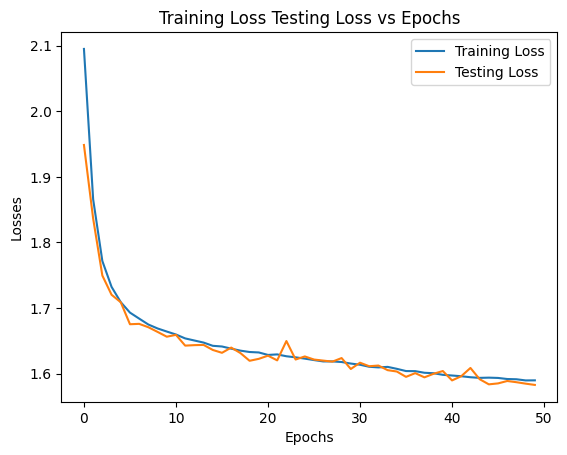

In [15]:
plt.title("Training Loss Testing Loss vs Epochs")
plt.plot(ep, TrainLoss, label="Training Loss")
plt.plot(ep, TestLoss, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

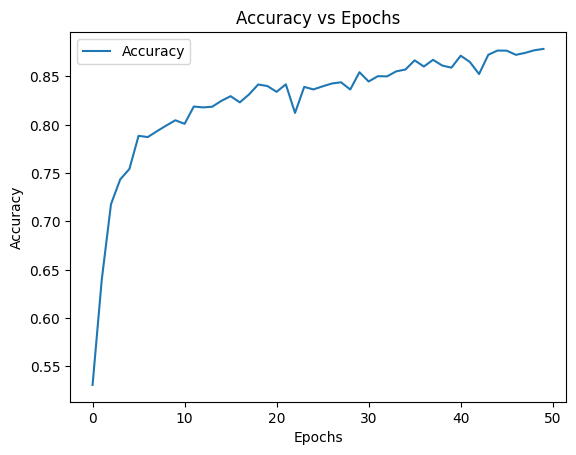

In [16]:
plt.title("Accuracy vs Epochs")
plt.plot(ep, Acc, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

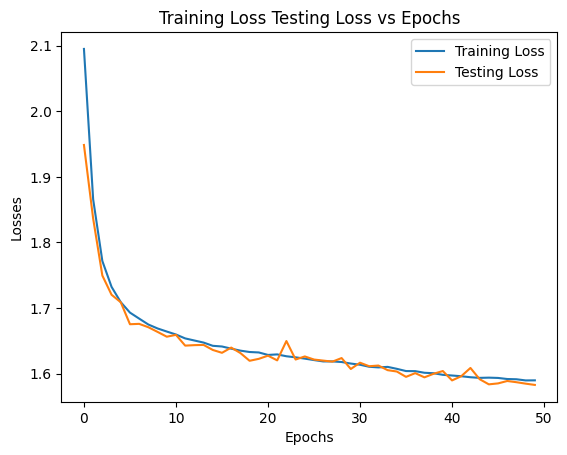

In [17]:
plt.title("Training Loss Testing Loss vs Epochs")
plt.plot(ep, TrainLoss, label="Training Loss")
plt.plot(ep, TestLoss, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.savefig("Loss.png",pad_inches=0.2)
plt.show()

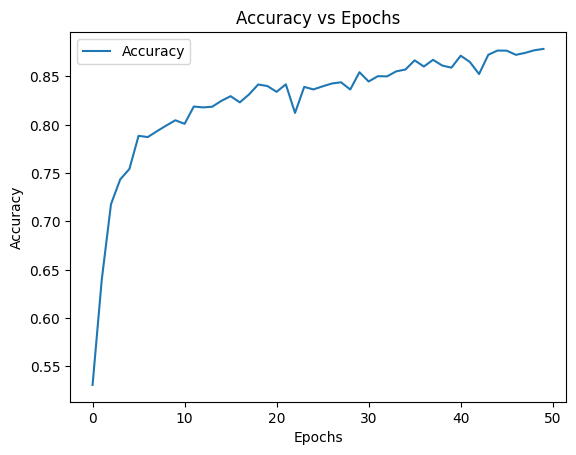

In [18]:
plt.title("Accuracy vs Epochs")
plt.plot(ep, Acc, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy.png",pad_inches=0.2)
plt.show()